## Finetuning SAM for liquid (water) segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists
import numpy as np
import PIL
import matplotlib.pyplot as plt
from glob import glob
import cv2
from natsort import natsorted
# from tqdm import tqdm_notebook
import tqdm

import shared_utils as su

### Define dataset

In [3]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [4]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, processor, imsize=(256, 256)):

        self.data_dir = "../data/datasets/pouring_dataset"
        self.load_dataset(self.data_dir)
        self.imsize = imsize

        self.processor = processor

    def load_dataset(self, data_dir):
        self.image_dir = join(data_dir, "fakeB")
        self.amask_dir = join(data_dir, "trainA_liquid_masks")
        self.cup_mask_dir = join(data_dir, "trainA_cup_masks")

        data = []
        n_images = len(glob(join(self.image_dir, "*.png")))
        for i in tqdm.notebook.tqdm(range(n_images), desc="Loading data"):
            item = {
                "image_path": join(self.image_dir, f"rgb_{i}.png"),
                "liquid_mask_path": join(self.amask_dir, f"liquid_mask_{i}.npy"),
                "cup_mask_path": join(self.cup_mask_dir, f"cup_mask_{i}.npy"),
            }
            data.append(item)
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx, visualize_example=False):
        item = self.data[idx]

        image_path = item["image_path"]
        assert exists(image_path), f"Image does not exist at {image_path}."
        image = PIL.Image.open(image_path)
        # Need to resize for SAM compatibility
        image = image.resize(self.imsize)

        liquid_mask_path = item["liquid_mask_path"]
        assert exists(liquid_mask_path), f"Liquid mask does not exist at {liquid_mask_path}."
        liquid_mask = np.load(liquid_mask_path)
        # Need to resize for SAM compatability
        liquid_mask = su.viz.resize_mask(liquid_mask, self.imsize)
        # Binarize
        liquid_mask = su.viz.binarize_mask(liquid_mask, 0.95)

        cup_mask_path = item["cup_mask_path"]
        assert exists(cup_mask_path), f"Liquid mask does not exist at {cup_mask_path}."
        cup_mask = np.load(cup_mask_path)
        # Need to resize for SAM compatability
        cup_mask = su.viz.resize_mask(cup_mask, self.imsize)
        cup_bbox = su.viz.mask_to_bounding_box(cup_mask, perturbation=10)
        prompt = cup_bbox
        # Binarize
        cup_mask = su.viz.binarize_mask(cup_mask, 0.45)

        if visualize_example:
            # Helpers for visualization
            liquid_mask_pil = su.viz.alpha_mask_to_pil_image(liquid_mask, 0.95)
            cup_mask_pil = su.viz.alpha_mask_to_pil_image(cup_mask, 0.45)
            image_with_liquid_mask = su.viz.add_mask_on_image(image, liquid_mask_pil, color="blue")
            image_with_cup_mask = su.viz.add_mask_on_image(image, cup_mask_pil, color="yellow")
            image_with_cup_bbox = su.viz.add_bbox_on_image(image, cup_bbox, color="yellow")
            display(
                su.viz.concat_images(
                    [image, image_with_liquid_mask, image_with_cup_mask, image_with_cup_bbox]
                )
            )

        # image = item["image"]
        # ground_truth_mask = np.array(item["label"])

        # # get bounding box prompt
        # prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = liquid_mask

        return inputs

In [5]:
train_dataset = SAMDataset(processor=processor)

Loading data:   0%|          | 0/2231 [00:00<?, ?it/s]

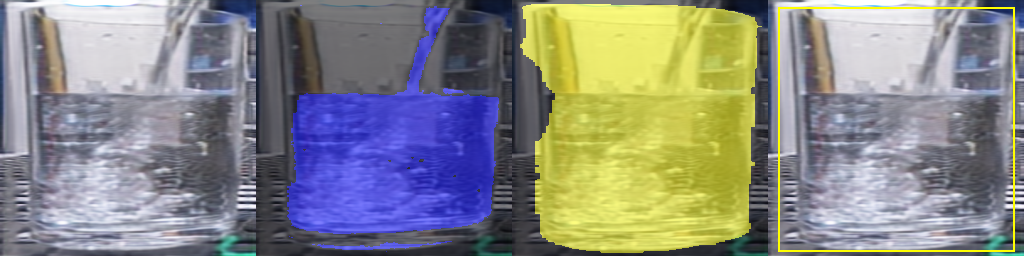

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [7]:
example = train_dataset.__getitem__(10, visualize_example=True)
for k,v in example.items():
    print(k,v.shape)

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


### Load the model

In [11]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

### Train the model

In [14]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  1%|██                                                                                                                                                         | 15/1116 [00:05<06:25,  2.86it/s]